<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Kalman Filtering &  Lod-Distance Path Loss & Shadowing Modeling
</p>

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit 

In [3]:
# Load data and convert time column
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771962 entries, 0 to 771961
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   time         771962 non-null  datetime64[ns, UTC]
 1   device_id    771962 non-null  object             
 2   co2          771962 non-null  float64            
 3   humidity     771962 non-null  float64            
 4   pm25         771962 non-null  float64            
 5   pressure     771962 non-null  float64            
 6   temperature  771962 non-null  float64            
 7   rssi         771962 non-null  float64            
 8   snr          771962 non-null  float64            
 9   SF           771962 non-null  int64              
 10  frequency    771962 non-null  float64            
 11  f_count      771962 non-null  float64            
 12  p_count      771962 non-null  float64            
 13  toa          771962 non-null  float64            
 14  dist

In [4]:
# 80-20 stratified train-test split ensuring all 6 devices are included in both sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['device_id'], random_state=200)

# Sort by time for clarity in plotting
train_df = train_df.sort_values('time')
test_df = test_df.sort_values('time')

In [5]:
# Define Kalman filter function and apply it separately on train and test sets per device
def kalman_filter_rssi(rssi_measurements):
    """
    Applies a simple 1D Kalman filter (random-walk model) to RSSI measurements.
    """
    kf = KalmanFilter(
        initial_state_mean=rssi_measurements[0],
        observation_covariance=0.5,
        transition_covariance=0.01
    )
    # kf.smooth returns (smoothed_state_means, smoothed_state_covariances)
    return kf.smooth(rssi_measurements)[0].flatten()

# Apply Kalman filter on training data per device
train_df['filtered_rssi'] = train_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)
# Compute exp_pl_filtered for training data using: 
                    # exp_pl_filtered = 14 - 1 + 1.4 + 3 - filtered_rssi
                    # From: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3, tx_cl=0
train_df['exp_pl_filtered'] = 14 - 1 + 1.4 + 3 - train_df['filtered_rssi']

# Apply Kalman filter on test data per device (separately)
test_df['filtered_rssi'] = test_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)

# Compute exp_pl_filtered for test data
test_df['exp_pl_filtered'] = 14 - 1 + 1.4 + 3 - test_df['filtered_rssi']

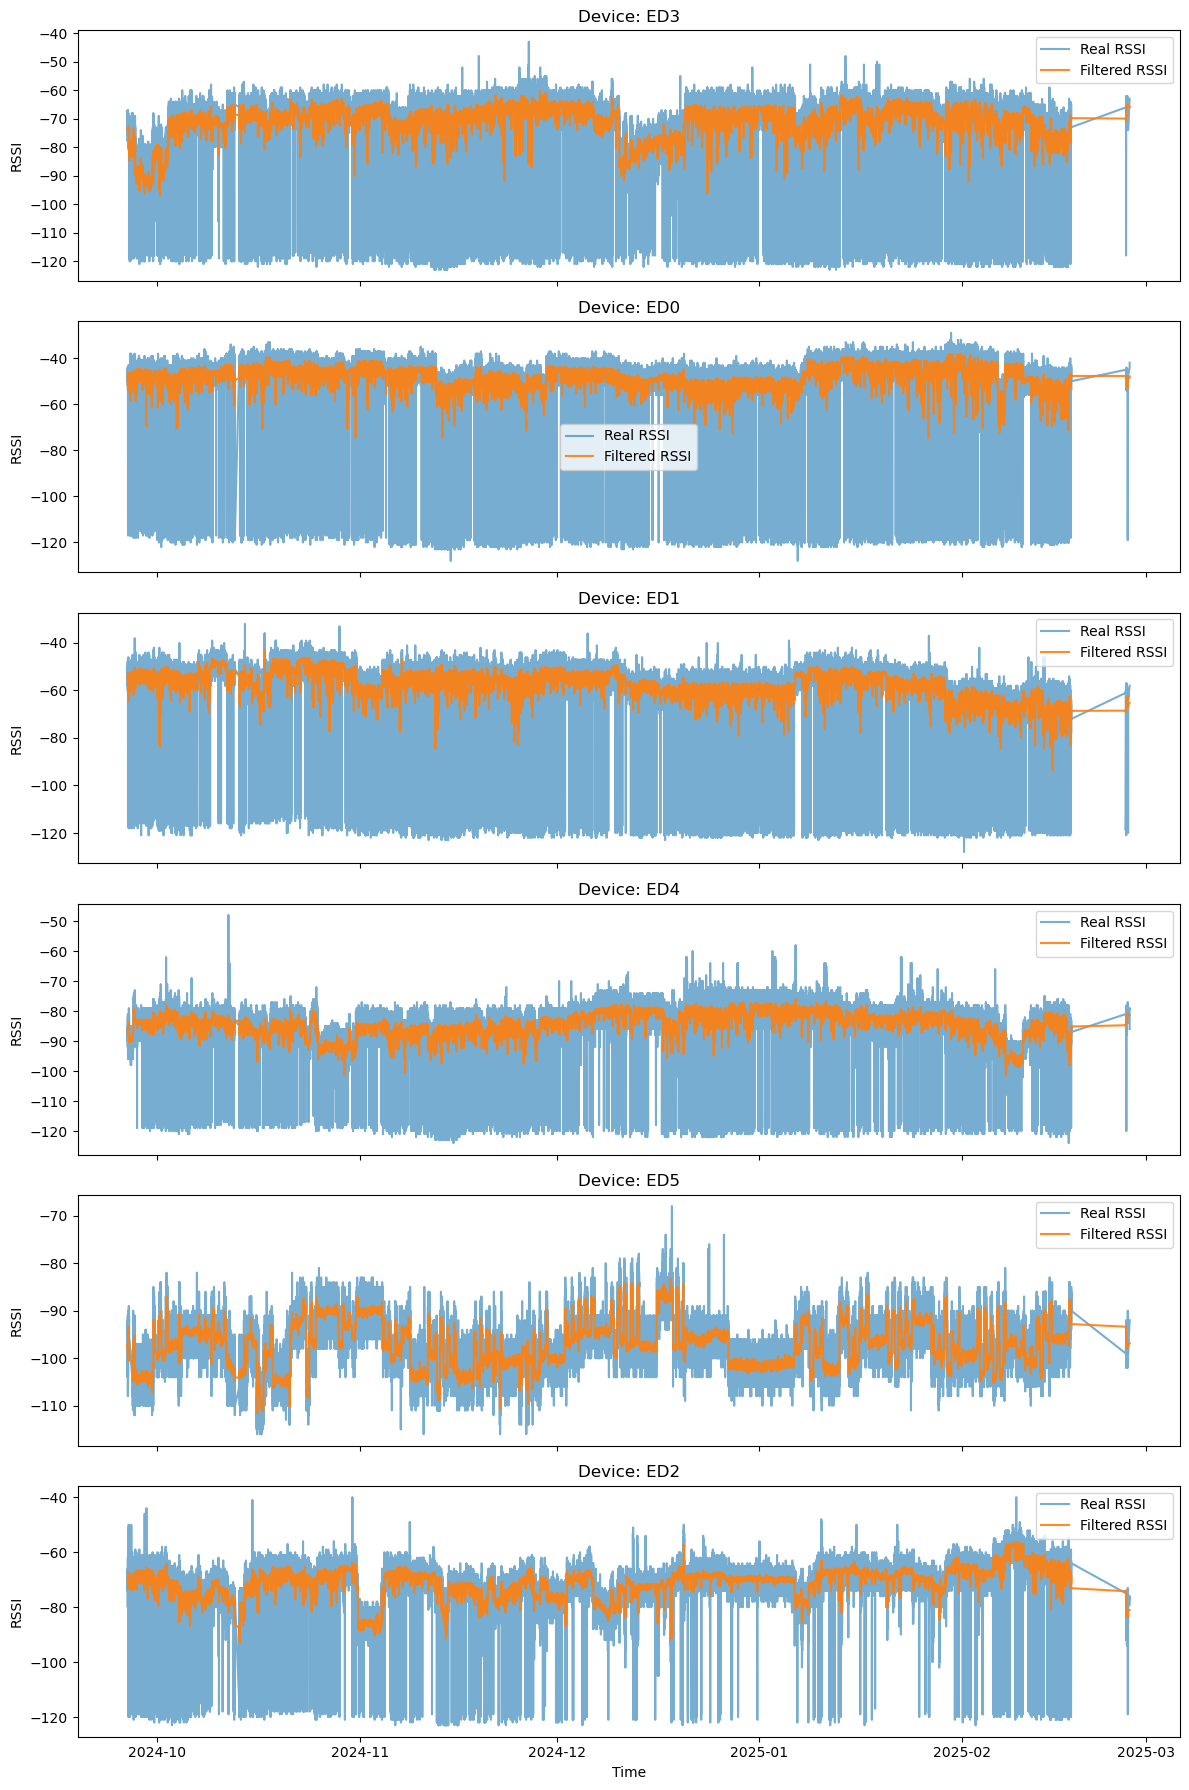

In [6]:
# Plot train data (Real vs. Filtered RSSI) for each device
device_ids = train_df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 3*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = train_df[train_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

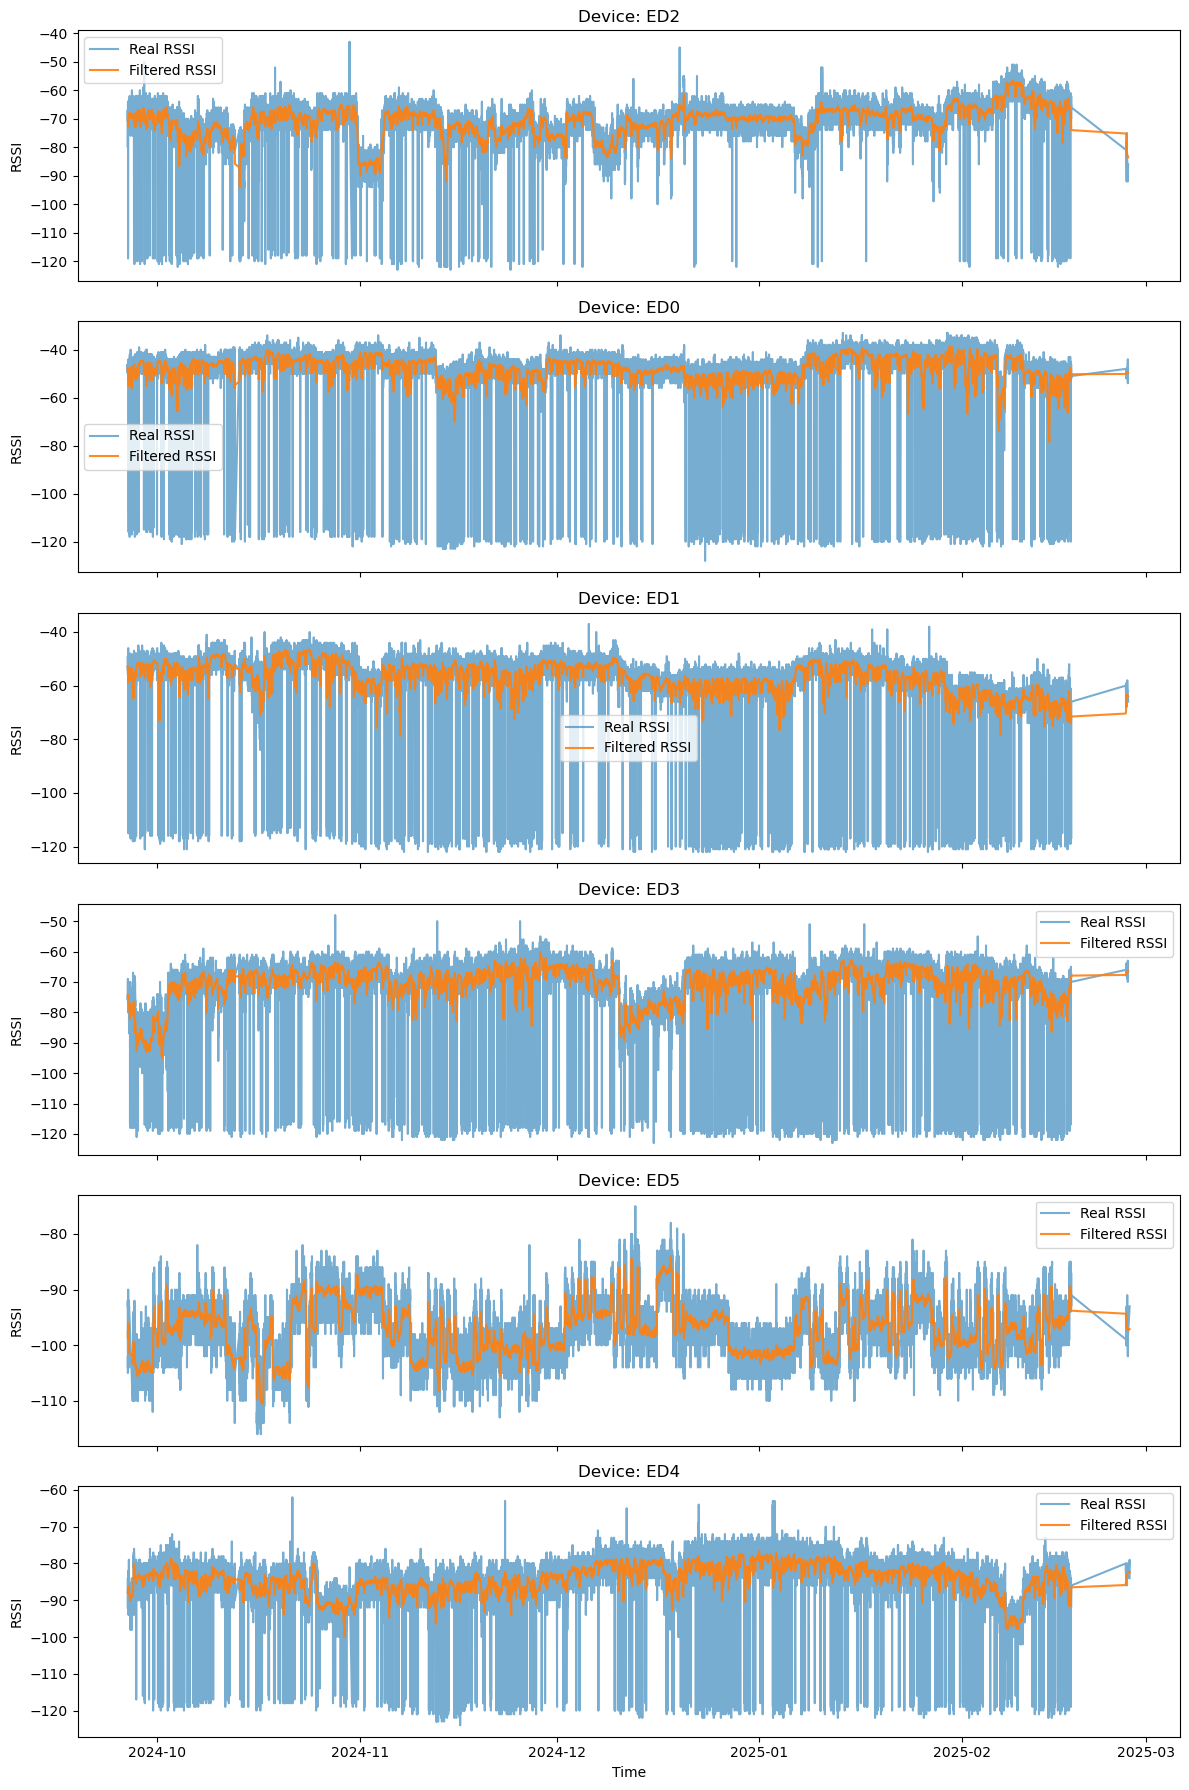

In [7]:
# Plot test data (Real vs. Filtered RSSI) for each device
device_ids_test = test_df['device_id'].unique()
num_devices_test = len(device_ids_test)
fig, axes = plt.subplots(nrows=num_devices_test, ncols=1, figsize=(12, 3*num_devices_test), sharex=True)
if num_devices_test == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids_test):
    device_data = test_df[test_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [8]:
# Feature Extraction & Model Function Definitions
features = ['distance', 'frequency', 'c_walls', 'w_walls', 'co2', 
            'humidity', 'pm25', 'pressure', 'temperature', 'snr']
X_train = np.column_stack([train_df[feat].values for feat in features])
X_test  = np.column_stack([test_df[feat].values for feat in features])

# Targets: raw and filtered exp_pl
y_train_raw  = train_df['exp_pl'].values
y_test_raw   = test_df['exp_pl'].values
y_train_filt = train_df['exp_pl_filtered'].values
y_test_filt  = test_df['exp_pl_filtered'].values

# LDPLM-MW: using distance, c_walls, w_walls (indices 0,2,3)
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1
    return PL_d0 + 10 * n * np.log10(d/d0) + c_walls * L_c + w_walls * L_w

# LDPLM-MW-EP: using all 10 features
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, freq, c_walls, w_walls, co2, hum, pm25, pres, temp, snr = x
    d0 = 1
    return (PL_d0 + 10 * n * np.log10(d/d0) + 20*np.log10(freq) +
            c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * hum + a_pm25 * pm25 +
            a_pres * pres + a_temp * temp + snr * k_snr)

idx_mw = [0, 2, 3]
idx_ep = list(range(10))

In [9]:
# Feature Extraction & Model Function Definitions
features = ['distance', 'frequency', 'c_walls', 'w_walls', 'co2', 
            'humidity', 'pm25', 'pressure', 'temperature', 'snr']
X_train = np.column_stack([train_df[feat].values for feat in features])
X_test  = np.column_stack([test_df[feat].values for feat in features])

# Targets: raw and filtered exp_pl
y_train_raw  = train_df['exp_pl'].values
y_test_raw   = test_df['exp_pl'].values
y_train_filt = train_df['exp_pl_filtered'].values
y_test_filt  = test_df['exp_pl_filtered'].values

# LDPLM-MW: using distance, c_walls, w_walls (indices 0,2,3)
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1
    return PL_d0 + 10 * n * np.log10(d/d0) + c_walls * L_c + w_walls * L_w

# LDPLM-MW-EP: using all 10 features
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, freq, c_walls, w_walls, co2, hum, pm25, pres, temp, snr = x
    d0 = 1
    return (PL_d0 + 10 * n * np.log10(d/d0) + 20*np.log10(freq) +
            c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * hum + a_pm25 * pm25 +
            a_pres * pres + a_temp * temp + snr * k_snr)

idx_mw = [0, 2, 3]
idx_ep = list(range(10))

In [10]:
# Model Fitting & Evaluation (Raw and Filtered)

# Initial guesses
initial_guess_mw = [30, 2, 5, 3]
initial_guess_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]

# --- Fit on Raw exp_pl ---
popt_mw_raw, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_raw, p0=initial_guess_mw, maxfev=100000)
popt_ep_raw, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_raw, p0=initial_guess_ep, maxfev=100000)

# --- Fit on Filtered exp_pl ---
popt_mw_filt, _ = curve_fit(
    log_distance_path_loss_separate_walls,
    X_train[:, idx_mw].T, y_train_filt, p0=initial_guess_mw, maxfev=100000)
popt_ep_filt, _ = curve_fit(
    log_distance_path_loss_with_env_params,
    X_train[:, idx_ep].T, y_train_filt, p0=initial_guess_ep, maxfev=100000)

# --- Predictions ---
# Raw models
y_pred_mw_raw   = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_raw)
y_pred_ep_raw   = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_raw)
y_train_pred_mw_raw = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_raw)
y_train_pred_ep_raw = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_raw)
# Filtered models
y_pred_mw_filt  = log_distance_path_loss_separate_walls(X_test[:, idx_mw].T, *popt_mw_filt)
y_pred_ep_filt  = log_distance_path_loss_with_env_params(X_test[:, idx_ep].T, *popt_ep_filt)
y_train_pred_mw_filt = log_distance_path_loss_separate_walls(X_train[:, idx_mw].T, *popt_mw_filt)
y_train_pred_ep_filt = log_distance_path_loss_with_env_params(X_train[:, idx_ep].T, *popt_ep_filt)

# --- Shadowing (train) & Metrics ---
shadowing_mw_raw  = y_train_raw - y_train_pred_mw_raw
sigma_mw_raw      = np.std(shadowing_mw_raw)
shadowing_ep_raw  = y_train_raw - y_train_pred_ep_raw
sigma_ep_raw      = np.std(shadowing_ep_raw)
shadowing_mw_filt = y_train_filt - y_train_pred_mw_filt
sigma_mw_filt     = np.std(shadowing_mw_filt)
shadowing_ep_filt = y_train_filt - y_train_pred_ep_filt
sigma_ep_filt     = np.std(shadowing_ep_filt)

# Test metrics
rmse_mw_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_mw_raw))
r2_mw_raw_test    = r2_score(y_test_raw, y_pred_mw_raw)
rmse_ep_raw_test  = np.sqrt(mean_squared_error(y_test_raw, y_pred_ep_raw))
r2_ep_raw_test    = r2_score(y_test_raw, y_pred_ep_raw)
rmse_mw_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_mw_filt))
r2_mw_filt_test   = r2_score(y_test_filt, y_pred_mw_filt)
rmse_ep_filt_test = np.sqrt(mean_squared_error(y_test_filt, y_pred_ep_filt))
r2_ep_filt_test   = r2_score(y_test_filt, y_pred_ep_filt)

# Train metrics
rmse_mw_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_mw_raw))
r2_mw_raw_train    = r2_score(y_train_raw, y_train_pred_mw_raw)
rmse_ep_raw_train  = np.sqrt(mean_squared_error(y_train_raw, y_train_pred_ep_raw))
r2_ep_raw_train    = r2_score(y_train_raw, y_train_pred_ep_raw)
rmse_mw_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_mw_filt))
r2_mw_filt_train   = r2_score(y_train_filt, y_train_pred_mw_filt)
rmse_ep_filt_train = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_ep_filt))
r2_ep_filt_train   = r2_score(y_train_filt, y_train_pred_ep_filt)

In [11]:
# Parameter & Metrics Comparison

# Parameters from curve fitting
params_mw_raw  = {'PL(d0)': popt_mw_raw[0], 'n': popt_mw_raw[1], 'L_c': popt_mw_raw[2], 'L_w': popt_mw_raw[3]}
params_ep_raw  = {'PL(d0)': popt_ep_raw[0], 'n': popt_ep_raw[1], 'L_c': popt_ep_raw[2], 'L_w': popt_ep_raw[3],
                  'a_co2': popt_ep_raw[4], 'a_hum': popt_ep_raw[5], 'a_pm25': popt_ep_raw[6],
                  'a_pres': popt_ep_raw[7], 'a_temp': popt_ep_raw[8], 'k_snr': popt_ep_raw[9]}
params_mw_filt = {'PL(d0)': popt_mw_filt[0], 'n': popt_mw_filt[1], 'L_c': popt_mw_filt[2], 'L_w': popt_mw_filt[3]}
params_ep_filt = {'PL(d0)': popt_ep_filt[0], 'n': popt_ep_filt[1], 'L_c': popt_ep_filt[2], 'L_w': popt_ep_filt[3],
                  'a_co2': popt_ep_filt[4], 'a_hum': popt_ep_filt[5], 'a_pm25': popt_ep_filt[6],
                  'a_pres': popt_ep_filt[7], 'a_temp': popt_ep_filt[8], 'k_snr': popt_ep_filt[9]}

# Build table of parameters for all 4 models
shared_params = ['PL(d0)', 'n', 'L_c', 'L_w']
unique_params = ['a_co2', 'a_hum', 'a_pm25', 'a_pres', 'a_temp', 'k_snr']
parameter_list = shared_params + unique_params

ldplm_mw_raw_vals  = [params_mw_raw.get(p, '-') for p in parameter_list]
ldplm_ep_raw_vals  = [params_ep_raw.get(p, '-') for p in parameter_list]
ldplm_mw_filt_vals = [params_mw_filt.get(p, '-') for p in parameter_list]
ldplm_ep_filt_vals = [params_ep_filt.get(p, '-') for p in parameter_list]

params_comp_df = pd.DataFrame({
    'LDPLM-MW (raw)': ldplm_mw_raw_vals,
    'LDPLM-MW (filt)': ldplm_mw_filt_vals,
    'LDPLM-MW-EP (raw)': ldplm_ep_raw_vals,
    'LDPLM-MW-EP (filt)': ldplm_ep_filt_vals
}, index=parameter_list)

# Build Metrics DataFrame
metrics = ['RMSE (Train)', 'RMSE (Test)', 'R2 (Train)', 'R2 (Test)', 'σ (dB)']
metrics_values = {
    'LDPLM-MW (raw)': [rmse_mw_raw_train, rmse_mw_raw_test, r2_mw_raw_train, r2_mw_raw_test, sigma_mw_raw],
    'LDPLM-MW (filt)': [rmse_mw_filt_train, rmse_mw_filt_test, r2_mw_filt_train, r2_mw_filt_test, sigma_mw_filt],
    'LDPLM-MW-EP (raw)': [rmse_ep_raw_train, rmse_ep_raw_test, r2_ep_raw_train, r2_ep_raw_test, sigma_ep_raw],
    'LDPLM-MW-EP (filt)': [rmse_ep_filt_train, rmse_ep_filt_test, r2_ep_filt_train, r2_ep_filt_test, sigma_ep_filt]
}
metrics_df = pd.DataFrame(metrics_values, index=metrics)

# Output the two tables
print("\n=== Table of Parameters to be Compared ===\n")
display(params_comp_df)

print("\n=== Performance Metrics ===\n")
display(metrics_df)


=== Table of Parameters to be Compared ===



,LDPLM-MW (raw),LDPLM-MW (filt),LDPLM-MW-EP (raw),LDPLM-MW-EP (filt)
PL(d0),25.691532,25.691522,-5.097021,-26.386510
n,4.162582,4.162583,3.726436,4.106546
L_c,8.912605,8.912602,7.692759,8.744905
L_w,2.067889,2.067889,2.400750,2.024066
a_co2,-,-,-0.002539,-0.003965
a_hum,-,-,-0.037786,-0.053402
a_pm25,-,-,-0.174168,-0.157101
a_pres,-,-,0.001544,0.012853
a_temp,-,-,-0.021332,-0.096043
k_snr,-,-,-1.976547,-0.346986



=== Performance Metrics ===



,LDPLM-MW (raw),LDPLM-MW (filt),LDPLM-MW-EP (raw),LDPLM-MW-EP (filt)
RMSE (Train),10.369138,5.401826,7.959021,5.213348
RMSE (Test),10.303737,5.231447,7.931047,5.052073
R2 (Train),0.708746,0.899664,0.828405,0.906544
R2 (Test),0.711883,0.905525,0.829297,0.911893
σ (dB),10.369138,5.401826,7.959021,5.213348


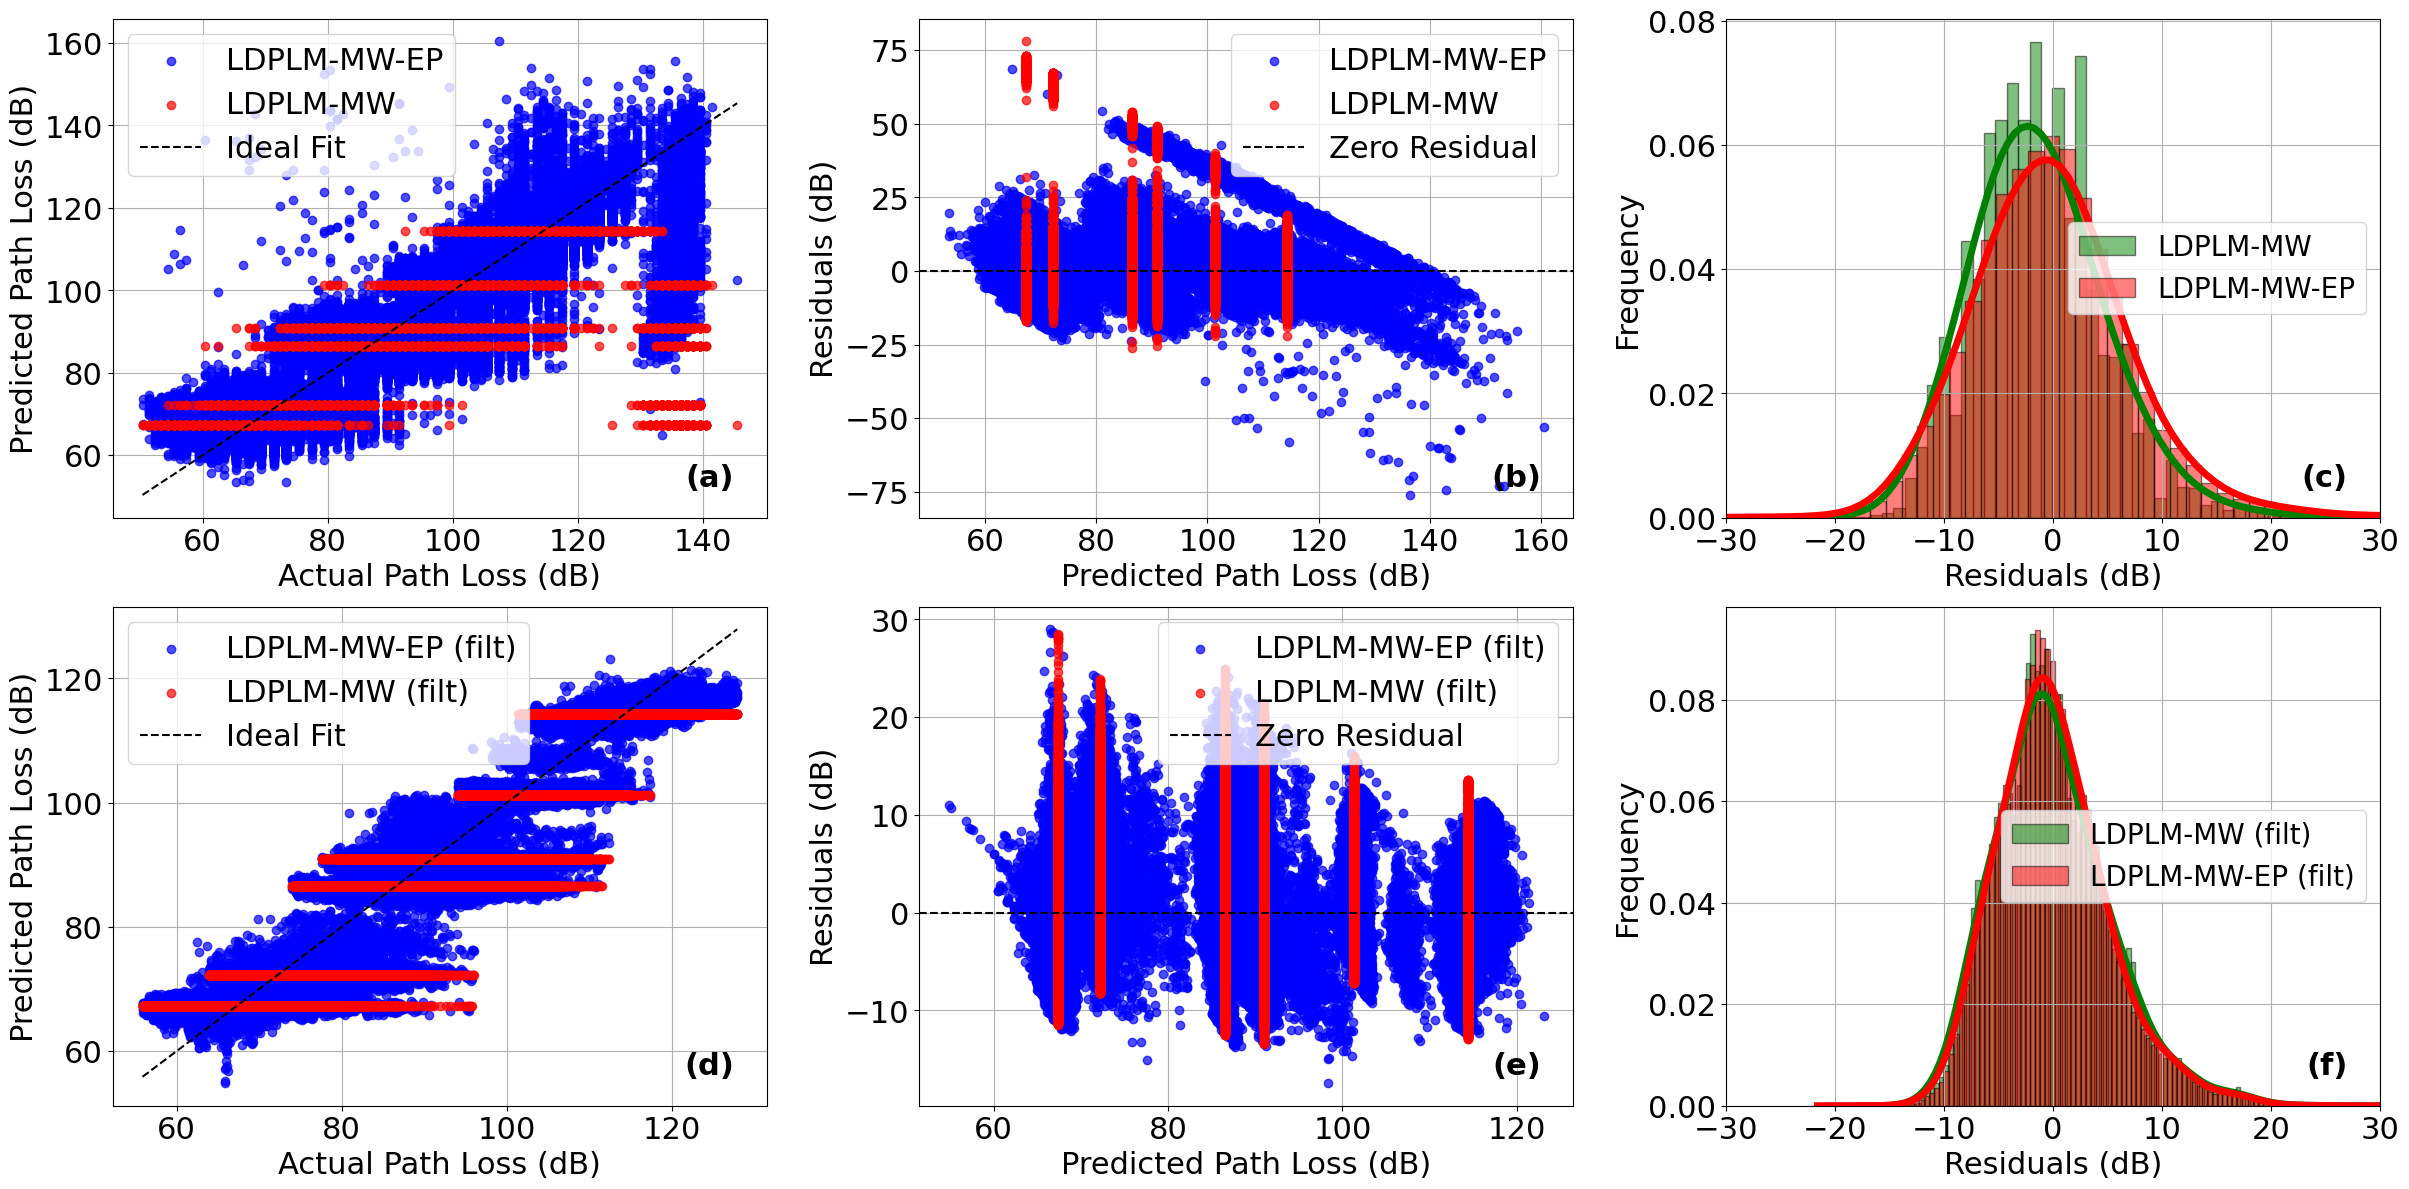


Residual Distribution Values:


,Mean (dB),Skewness
LDPLM-MW (raw),-0.014695,3.876611
LDPLM-MW (filt),-0.014696,0.640876
LDPLM-MW-EP (raw),0.019471,1.147790
LDPLM-MW-EP (filt),-0.006434,0.656054


In [12]:
# Combined Plots (Raw & Filtered) and Residual Distribution Table

# Compute test residuals for raw and filtered models
residuals_mw_test = y_test_raw - y_pred_mw_raw
residuals_ep_test = y_test_raw - y_pred_ep_raw
residuals_mw_test_filt = y_test_filt - y_pred_mw_filt
residuals_ep_test_filt = y_test_filt - y_pred_ep_filt

# Define plotting targets/predictions (raw & filtered)
PL_test_mw = y_test_raw        # Raw target for MW & EP (identical)
PL_test_ep = y_test_raw
PL_pred_mw = y_pred_mw_raw     # Raw predictions
PL_pred_ep = y_pred_ep_raw

PL_test_mw_filt = y_test_filt  # Filtered targets for MW & EP (identical)
PL_test_ep_filt = y_test_filt
PL_pred_mw_filt = y_pred_mw_filt  # Filtered predictions
PL_pred_ep_filt = y_pred_ep_filt

# Define ideal fit line boundaries
min_PL = min(PL_test_ep.min(), PL_test_mw.min())
max_PL = max(PL_test_ep.max(), PL_test_mw.max())
min_PL_filt = min(PL_test_ep_filt.min(), PL_test_mw_filt.min())
max_PL_filt = max(PL_test_ep_filt.max(), PL_test_mw_filt.max())

# Create a figure with 2 rows x 3 columns (Row 1: Raw, Row 2: Filtered)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# -------------------- Row 1: Raw Models --------------------
# (a) Actual vs Predicted Path Loss
ax = axes[0, 0]
ax.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
ax.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
ax.plot([min_PL, max_PL], [min_PL, max_PL], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(a)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (b) Residuals vs Predicted Path Loss
ax = axes[0, 1]
ax.scatter(PL_pred_ep, residuals_ep_test, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
ax.scatter(PL_pred_mw, residuals_mw_test, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(b)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (c) Histogram & KDE of Residuals
ax = axes[0, 2]
ax.hist(residuals_mw_test, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(c)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# -------------------- Row 2: Filtered Models --------------------
# (d) Actual vs Predicted Path Loss (Filtered)
ax = axes[1, 0]
ax.scatter(PL_test_ep_filt, PL_pred_ep_filt, alpha=0.7, label='LDPLM-MW-EP (filt)', color='blue', zorder=2)
ax.scatter(PL_test_mw_filt, PL_pred_mw_filt, alpha=0.7, label='LDPLM-MW (filt)', color='red', zorder=3)
ax.plot([min_PL_filt, max_PL_filt], [min_PL_filt, max_PL_filt], 'k--', label='Ideal Fit', zorder=4)
ax.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper left')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(d)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (e) Residuals vs Predicted Path Loss (Filtered)
ax = axes[1, 1]
ax.scatter(PL_pred_ep_filt, residuals_ep_test_filt, alpha=0.7, label='LDPLM-MW-EP (filt)', color='blue', zorder=2)
ax.scatter(PL_pred_mw_filt, residuals_mw_test_filt, alpha=0.7, label='LDPLM-MW (filt)', color='red', zorder=3)
ax.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax.set_ylabel('Residuals (dB)', fontsize=22)
ax.legend(fontsize=22, loc='upper right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(e)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

# (f) Histogram & KDE of Residuals (Filtered)
ax = axes[1, 2]
ax.hist(residuals_mw_test_filt, bins=100, alpha=0.5, label='LDPLM-MW (filt)', color='green', edgecolor='k', density=True)
ax.hist(residuals_ep_test_filt, bins=100, alpha=0.5, label='LDPLM-MW-EP (filt)', color='red', edgecolor='k', density=True)
sns.kdeplot(residuals_mw_test_filt, color='green', bw_adjust=3, ax=ax, linewidth=5)
sns.kdeplot(residuals_ep_test_filt, color='red', bw_adjust=3, ax=ax, linewidth=5)
ax.set_xlabel('Residuals (dB)', fontsize=22)
ax.set_ylabel('Frequency', fontsize=22)
ax.set_xlim(-30, 30)
ax.legend(fontsize=20, loc='center right')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.text(0.95, 0.05, '(f)', transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='right')

plt.tight_layout()
plt.savefig('../all_data_files/All_Plots_as_Subplots_Kalman.png', dpi=1000)
plt.show()

# -------------------- Residual Distribution Table (Test Data) --------------------
resid_mean_mw      = round(np.mean(residuals_mw_test), 6)
resid_skew_mw      = round(pd.Series(residuals_mw_test).skew(), 6)
resid_mean_ep      = round(np.mean(residuals_ep_test), 6)
resid_skew_ep      = round(pd.Series(residuals_ep_test).skew(), 6)
resid_mean_mw_filt = round(np.mean(residuals_mw_test_filt), 6)
resid_skew_mw_filt = round(pd.Series(residuals_mw_test_filt).skew(), 6)
resid_mean_ep_filt = round(np.mean(residuals_ep_test_filt), 6)
resid_skew_ep_filt = round(pd.Series(residuals_ep_test_filt).skew(), 6)

resid_df = pd.DataFrame({
    'Mean (dB)': [resid_mean_mw, resid_mean_mw_filt, resid_mean_ep, resid_mean_ep_filt],
    'Skewness': [resid_skew_mw, resid_skew_mw_filt, resid_skew_ep, resid_skew_ep_filt]
}, index=['LDPLM-MW (raw)', 'LDPLM-MW (filt)', 'LDPLM-MW-EP (raw)', 'LDPLM-MW-EP (filt)'])

print("\nResidual Distribution Values:")
display(resid_df)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Distance Estimation for Localization
</p>

In [14]:
# ----------------------------
# Define Distance Inversion Functions
# ----------------------------
def estimate_distance_modelA(PL, PL_d0, n, L_c, L_w, W_c, W_w, shadow_removal=False, sigma_shadow=0):
    # LDPLM-MW:
    # PL = PL(d0) + 10*n*log10(d) + (W_c*L_c + W_w*L_w) + ε
    PL_eff = PL - sigma_shadow if shadow_removal else PL
    return 10 ** ((PL_eff - PL_d0 - (W_c * L_c + W_w * L_w)) / (10 * n))

def estimate_distance_modelB(PL, PL_d0, n, L_c, L_w, f, theta_E, E_matrix, k_snr, SNR, W_c, W_w, shadow_removal=False, sigma_shadow=0):
    # LDPLM-MW-EP:
    # PL = PL(d0) + 10*n*log10(d) + 20*log10(f) + (W_c*L_c+W_w*L_w)
    #      + (θ1*E1 + ... + θ5*E5) + k_SNR*SNR + ε
    PL_eff = PL - sigma_shadow if shadow_removal else PL
    env_term = np.dot(theta_E, E_matrix)  # E_matrix shape: (5, number_of_samples)
    return 10 ** ((PL_eff - PL_d0 - 20*np.log10(f) - (W_c * L_c + W_w * L_w) - env_term - k_snr * SNR) / (10 * n))

# ----------------------------
# Prepare Environmental Data for Model B
# ----------------------------
E_matrix_test = np.array([
    test_df['co2'].values,
    test_df['humidity'].values,
    test_df['pm25'].values,
    test_df['pressure'].values,
    test_df['temperature'].values
])
f_test   = test_df['frequency'].values
W_c_test = test_df['c_walls'].values
W_w_test = test_df['w_walls'].values
SNR_test = test_df['snr'].values

# ----------------------------
# Compute Distance Estimates (using full PL, i.e. shadow included, ε neglected)
# ----------------------------
# Model A (LDPLM-MW)
d_A_raw = estimate_distance_modelA(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_mw_raw[0],
    n = popt_mw_raw[1],
    L_c = popt_mw_raw[2],
    L_w = popt_mw_raw[3],
    W_c = W_c_test,
    W_w = W_w_test
)
d_A_filt = estimate_distance_modelA(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_mw_filt[0],
    n = popt_mw_filt[1],
    L_c = popt_mw_filt[2],
    L_w = popt_mw_filt[3],
    W_c = W_c_test,
    W_w = W_w_test
)

# Model B (LDPLM-MW-EP)
theta_E_raw  = popt_ep_raw[4:9]
theta_E_filt = popt_ep_filt[4:9]

d_B_raw = estimate_distance_modelB(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_ep_raw[0],
    n = popt_ep_raw[1],
    L_c = popt_ep_raw[2],
    L_w = popt_ep_raw[3],
    f = f_test,
    theta_E = theta_E_raw,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_raw[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)
d_B_filt = estimate_distance_modelB(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_ep_filt[0],
    n = popt_ep_filt[1],
    L_c = popt_ep_filt[2],
    L_w = popt_ep_filt[3],
    f = f_test,
    theta_E = theta_E_filt,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_filt[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test
)

# ----------------------------
# Compute Metrics (ε neglected)
# ----------------------------
def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2

true_distance = test_df['distance'].values

metrics_neglected = {
    'Model A Raw': compute_metrics(true_distance, d_A_raw),
    'Model A Filt': compute_metrics(true_distance, d_A_filt),
    'Model B Raw': compute_metrics(true_distance, d_B_raw),
    'Model B Filt': compute_metrics(true_distance, d_B_filt)
}

metrics_df_neglected = pd.DataFrame(metrics_neglected, index=['MAE', 'RMSE', 'R²'])
print("\n=== Distance Estimation Metrics (ε neglected) ===\n")
display(metrics_df_neglected)

# Compute absolute errors and CDF for ε neglected
def compute_cdf(errors, bins=100):
    hist_vals, bin_edges = np.histogram(errors, bins=bins, density=True)
    cdf_vals = np.cumsum(hist_vals * np.diff(bin_edges))
    return bin_edges[1:], cdf_vals

error_A_raw  = np.abs(true_distance - d_A_raw)
error_A_filt = np.abs(true_distance - d_A_filt)
error_B_raw  = np.abs(true_distance - d_B_raw)
error_B_filt = np.abs(true_distance - d_B_filt)

x_A_raw,  cdf_A_raw  = compute_cdf(error_A_raw)
x_A_filt, cdf_A_filt = compute_cdf(error_A_filt)
x_B_raw,  cdf_B_raw  = compute_cdf(error_B_raw)
x_B_filt, cdf_B_filt = compute_cdf(error_B_filt)

# ----------------------------
# Compute Distance Estimates with Shadow Removed (ε integrated)
# ----------------------------
# Model A (LDPLM-MW)
d_A_raw_no_shadow = estimate_distance_modelA(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_mw_raw[0],
    n = popt_mw_raw[1],
    L_c = popt_mw_raw[2],
    L_w = popt_mw_raw[3],
    W_c = W_c_test,
    W_w = W_w_test,
    shadow_removal = True,
    sigma_shadow = sigma_mw_raw
)
d_A_filt_no_shadow = estimate_distance_modelA(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_mw_filt[0],
    n = popt_mw_filt[1],
    L_c = popt_mw_filt[2],
    L_w = popt_mw_filt[3],
    W_c = W_c_test,
    W_w = W_w_test,
    shadow_removal = True,
    sigma_shadow = sigma_mw_filt
)

# Model B (LDPLM-MW-EP)
d_B_raw_no_shadow = estimate_distance_modelB(
    PL = test_df['exp_pl'].values,
    PL_d0 = popt_ep_raw[0],
    n = popt_ep_raw[1],
    L_c = popt_ep_raw[2],
    L_w = popt_ep_raw[3],
    f = f_test,
    theta_E = theta_E_raw,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_raw[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test,
    shadow_removal = True,
    sigma_shadow = sigma_ep_raw
)
d_B_filt_no_shadow = estimate_distance_modelB(
    PL = test_df['exp_pl_filtered'].values,
    PL_d0 = popt_ep_filt[0],
    n = popt_ep_filt[1],
    L_c = popt_ep_filt[2],
    L_w = popt_ep_filt[3],
    f = f_test,
    theta_E = theta_E_filt,
    E_matrix = E_matrix_test,
    k_snr = popt_ep_filt[9],
    SNR = SNR_test,
    W_c = W_c_test,
    W_w = W_w_test,
    shadow_removal = True,
    sigma_shadow = sigma_ep_filt
)

# ----------------------------
# Compute Metrics (ε integrated)
# ----------------------------
metrics_integrated = {
    'Model A Raw ': compute_metrics(true_distance, d_A_raw_no_shadow),
    'Model A Filt ': compute_metrics(true_distance, d_A_filt_no_shadow),
    'Model B Raw ': compute_metrics(true_distance, d_B_raw_no_shadow),
    'Model B Filt ': compute_metrics(true_distance, d_B_filt_no_shadow)
}

metrics_df_integrated = pd.DataFrame(metrics_integrated, index=['MAE', 'RMSE', 'R²'])
print("\n=== Distance Estimation Metrics (ε integrated) ===\n")
display(metrics_df_integrated)

# Compute absolute errors and CDF for ε integrated
error_A_raw_no_shadow  = np.abs(true_distance - d_A_raw_no_shadow)
error_A_filt_no_shadow = np.abs(true_distance - d_A_filt_no_shadow)
error_B_raw_no_shadow  = np.abs(true_distance - d_B_raw_no_shadow)
error_B_filt_no_shadow = np.abs(true_distance - d_B_filt_no_shadow)

x_A_raw_no_shadow,  cdf_A_raw_no_shadow  = compute_cdf(error_A_raw_no_shadow)
x_A_filt_no_shadow, cdf_A_filt_no_shadow = compute_cdf(error_A_filt_no_shadow)
x_B_raw_no_shadow,  cdf_B_raw_no_shadow  = compute_cdf(error_B_raw_no_shadow)
x_B_filt_no_shadow, cdf_B_filt_no_shadow = compute_cdf(error_B_filt_no_shadow)


=== Distance Estimation Metrics (ε neglected) ===



,Model A Raw,Model A Filt,Model B Raw,Model B Filt
MAE,12.490350,5.106737,8.540654,4.914750
RMSE,47.283166,7.657686,15.692077,7.331351
R²,-13.792199,0.612015,-0.629223,0.644379



=== Distance Estimation Metrics (ε integrated) ===



,Model A Raw,Model A Filt,Model B Raw,Model B Filt
MAE,13.669745,6.446391,9.671551,6.334935
RMSE,27.840699,8.064562,12.811082,7.917235
R²,-4.128377,0.569690,-0.085904,0.585269


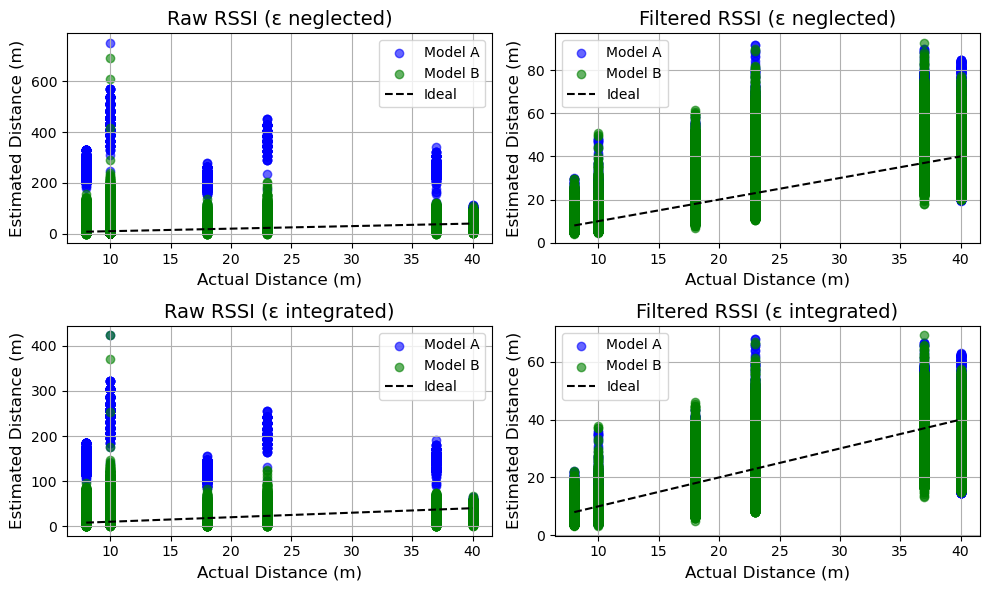

In [15]:
# ----------------------------
# Scatter Plots (2x2 for estimated vs actual distance)
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

def plot_scatter(ax, actual, pred_A, pred_B, title):
    ax.scatter(actual, pred_A, alpha=0.6, label='Model A', color='blue')
    ax.scatter(actual, pred_B, alpha=0.6, label='Model B', color='green')
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', label='Ideal')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Estimated Distance (m)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True)

# Top row: ε neglected
plot_scatter(axes[0,0], true_distance, d_A_raw, d_B_raw, 'Raw RSSI (ε neglected)')
plot_scatter(axes[0,1], true_distance, d_A_filt, d_B_filt, 'Filtered RSSI (ε neglected)')
# Bottom row: ε integrated
plot_scatter(axes[1,0], true_distance, d_A_raw_no_shadow, d_B_raw_no_shadow, 'Raw RSSI (ε integrated)')
plot_scatter(axes[1,1], true_distance, d_A_filt_no_shadow, d_B_filt_no_shadow, 'Filtered RSSI (ε integrated)')

plt.tight_layout()
plt.show()

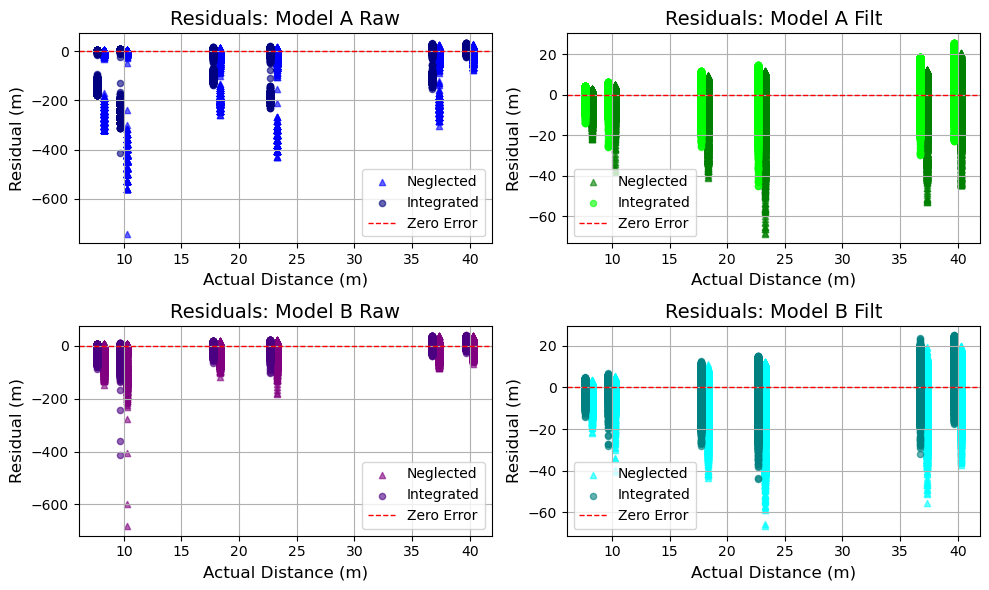

In [16]:
# ----------------------------
# Combined Residual Plots (2x2 for residuals vs. actual distance) – With Jitter for Overlap Visibility
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

titles    = ['Model A Raw', 'Model A Filt', 'Model B Raw', 'Model B Filt']
resid_neg = [
    true_distance - d_A_raw,
    true_distance - d_A_filt,
    true_distance - d_B_raw,
    true_distance - d_B_filt
]
resid_int = [
    true_distance - d_A_raw_no_shadow,
    true_distance - d_A_filt_no_shadow,
    true_distance - d_B_raw_no_shadow,
    true_distance - d_B_filt_no_shadow
]
colors_neg = ['blue', 'green', 'purple', 'cyan']
colors_int = ['navy', 'lime', 'indigo', 'teal']

# Define a jitter value (can adjust as needed)
jitter = 0.3  

for i, (ax, title, rn, ri, cn, ci) in enumerate(zip(axes.flatten(), titles, resid_neg, resid_int, colors_neg, colors_int)):
    # Add a slight offset to actual distance for each group to reveal overlapping points.
    ax.scatter(true_distance + jitter, rn, alpha=0.6, s=20, color=cn, marker='^', label='Neglected')
    ax.scatter(true_distance - jitter, ri, alpha=0.6, s=20, color=ci, marker='o', label='Integrated')
    ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Error')
    ax.set_xlabel('Actual Distance (m)', fontsize=12)
    ax.set_ylabel('Residual (m)', fontsize=12)
    ax.set_title(f'Residuals: {title}', fontsize=14)
    # Legend location: even-index subplots (column 0) at bottom right, odd (column 1) at bottom left.
    if i % 2 == 0:
        ax.legend(fontsize=10, loc='lower right')
    else:
        ax.legend(fontsize=10, loc='lower left')
    ax.grid(True)
    
plt.tight_layout()
plt.show()

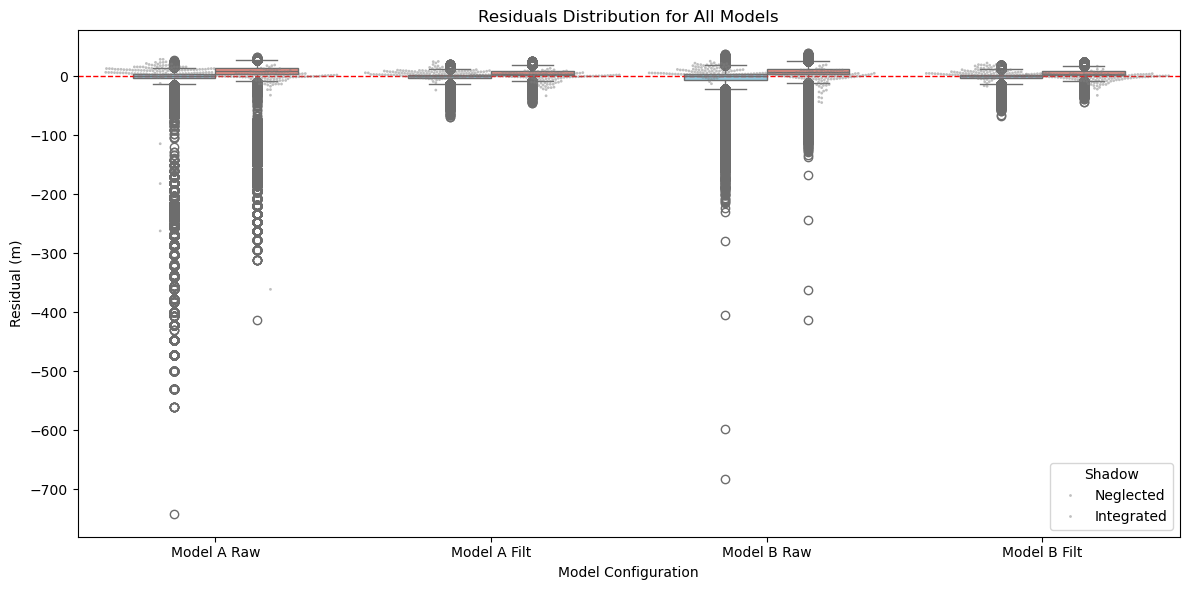

In [17]:
# Define model names and number of samples (full dataset)
models = ['Model A Raw', 'Model A Filt', 'Model B Raw', 'Model B Filt']
n = len(true_distance)

# Vectorized concatenation for residuals (ε neglected and ε integrated)
resid_neg = np.concatenate([
    true_distance - d_A_raw,
    true_distance - d_A_filt,
    true_distance - d_B_raw,
    true_distance - d_B_filt
])
models_neg = np.repeat(models, n)

resid_int = np.concatenate([
    true_distance - d_A_raw_no_shadow,
    true_distance - d_A_filt_no_shadow,
    true_distance - d_B_raw_no_shadow,
    true_distance - d_B_filt_no_shadow
])
models_int = np.repeat(models, n)

# Build DataFrame efficiently using full data for the boxplot
df_res = pd.DataFrame({
    'Residual': np.concatenate([resid_neg, resid_int]),
    'Model': np.concatenate([models_neg, models_int]),
    'Shadow': np.concatenate([np.repeat('Neglected', 4*n), np.repeat('Integrated', 4*n)])
})

# Subsample the data for the swarm plot (e.g., 1,000 points)
df_res_sample = df_res.sample(n=1000, random_state=42)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Residual', hue='Shadow', data=df_res,
            palette={'Neglected': 'skyblue', 'Integrated': 'salmon'}, width=0.6)
sns.swarmplot(x='Model', y='Residual', hue='Shadow', data=df_res_sample, dodge=True,
              palette={'Neglected': 'gray', 'Integrated': 'gray'}, alpha=0.5, size=2)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Shadow', loc='lower right')

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals Distribution for All Models')
plt.xlabel('Model Configuration')
plt.ylabel('Residual (m)')
plt.tight_layout()
plt.show()

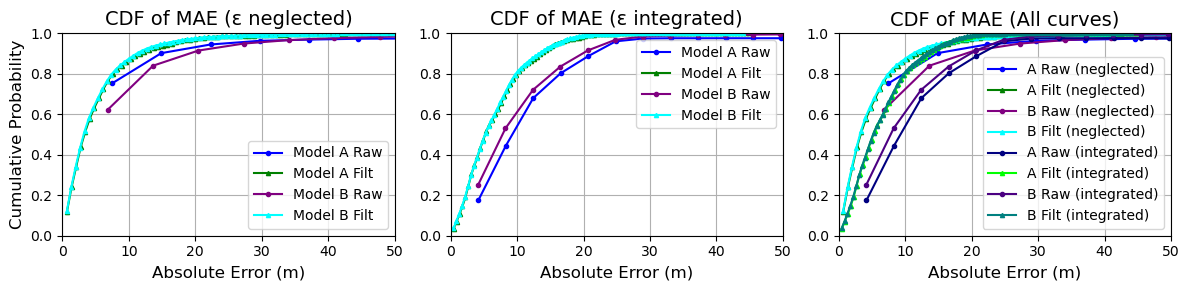

In [18]:
# ----------------------------
# CDF Plots (1x3 for CDF of absolute errors)
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Left: ε neglected CDFs
axes[0].plot(x_A_raw,  cdf_A_raw,  label='Model A Raw',  color='blue',   marker='o', markersize=3)
axes[0].plot(x_A_filt, cdf_A_filt, label='Model A Filt', color='green',  marker='^', markersize=3)
axes[0].plot(x_B_raw,  cdf_B_raw,  label='Model B Raw',  color='purple', marker='o', markersize=3)
axes[0].plot(x_B_filt, cdf_B_filt, label='Model B Filt', color='cyan',   marker='^', markersize=3)
axes[0].set_title('CDF of MAE (ε neglected)', fontsize=14)
axes[0].set_xlabel('Absolute Error (m)', fontsize=12)
axes[0].set_ylabel('Cumulative Probability', fontsize=12)
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].legend(fontsize=10)

# Middle: ε integrated CDFs
axes[1].plot(x_A_raw_no_shadow,  cdf_A_raw_no_shadow,  label='Model A Raw',  color='blue',   marker='o', markersize=3)
axes[1].plot(x_A_filt_no_shadow, cdf_A_filt_no_shadow, label='Model A Filt', color='green',  marker='^', markersize=3)
axes[1].plot(x_B_raw_no_shadow,  cdf_B_raw_no_shadow,  label='Model B Raw',  color='purple', marker='o', markersize=3)
axes[1].plot(x_B_filt_no_shadow, cdf_B_filt_no_shadow, label='Model B Filt', color='cyan',   marker='^', markersize=3)
axes[1].set_title('CDF of MAE (ε integrated)', fontsize=14)
axes[1].set_xlabel('Absolute Error (m)', fontsize=12)
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0, 1)
axes[1].grid(True)
axes[1].legend(fontsize=10)

# Right: All 8 curves in one plot
axes[2].plot(x_A_raw,  cdf_A_raw,  label='A Raw (neglected)',  color='blue',   marker='o', markersize=3)
axes[2].plot(x_A_filt, cdf_A_filt, label='A Filt (neglected)', color='green',  marker='^', markersize=3)
axes[2].plot(x_B_raw,  cdf_B_raw,  label='B Raw (neglected)',  color='purple', marker='o', markersize=3)
axes[2].plot(x_B_filt, cdf_B_filt, label='B Filt (neglected)', color='cyan',   marker='^', markersize=3)
axes[2].plot(x_A_raw_no_shadow,  cdf_A_raw_no_shadow,  label='A Raw (integrated)',  color='navy',    marker='o', markersize=3)
axes[2].plot(x_A_filt_no_shadow, cdf_A_filt_no_shadow, label='A Filt (integrated)', color='lime',    marker='^', markersize=3)
axes[2].plot(x_B_raw_no_shadow,  cdf_B_raw_no_shadow,  label='B Raw (integrated)',  color='indigo',  marker='o', markersize=3)
axes[2].plot(x_B_filt_no_shadow, cdf_B_filt_no_shadow, label='B Filt (integrated)', color='teal',    marker='^', markersize=3)
axes[2].set_title('CDF of MAE (All curves)', fontsize=14)
axes[2].set_xlabel('Absolute Error (m)', fontsize=12)
axes[2].set_xlim(0, 50)
axes[2].set_ylim(0, 1)
axes[2].grid(True)
axes[2].legend(fontsize=10, loc='lower right')

plt.tight_layout()
plt.show()